In [ ]:
!pip install -q "monai[all]" nibabel einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import imageio.v2 as imageio


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from monai.networks.nets import SwinUNETR
from pathlib import Path
import numpy as np
from google.colab import drive
import os, glob
from pathlib import Path
import time

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [ ]:
drive.mount("/content/drive")

BASE_DIR = Path("/content/drive/Shareddrives/TissueMotionForecasting")
DATA_ROOT = BASE_DIR / "scared_data" / "train" / "dataset_2"

print("DATA_ROOT:", DATA_ROOT)
keyframes = sorted(DATA_ROOT.glob("keyframe_*"))
print("\nFound keyframes:")
for kf in keyframes:
    print(" ", kf)
print("Total keyframes:", len(keyframes))

KEYFRAMES_TO_USE = [kf for kf in keyframes
                    if kf.name in ["keyframe_1", "keyframe_2", "keyframe_3"]]

print("\nKeyframes to use:")
for kf in KEYFRAMES_TO_USE:
    print(" ", kf)

for kf in KEYFRAMES_TO_USE:
    disp_dir = kf / "data" / "disparity"
    raw_files = sorted([f for f in disp_dir.glob("*.png")
                        if not f.name.startswith("colored")])
    colored_files = sorted(disp_dir.glob("colored_*.png"))

    print(f"\n[{kf.name}]")
    print("  disparity dir :", disp_dir)
    print("  RAW disparity :", len(raw_files))
    print("  COLORED       :", len(colored_files))

    if raw_files:
        print("   example RAW     :", raw_files[0].name)
    if colored_files:
        print("   example COLORED :", colored_files[0].name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_ROOT: /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2

Found keyframes:
  /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_1
  /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_2
  /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_3
  /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_4
  /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_5
Total keyframes: 5

Keyframes to use:
  /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_1
  /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_2
  /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/d

In [ ]:
CONTEXT_LEN = 3
FORECAST_HORIZON = 10
DISP_SCALE = 256.0

In [ ]:
class DisparityForecastDataset(Dataset):
    """
    Uses RAW disparity from:
      DATA_ROOT/keyframe_*/data/disparity/*.png

    - Ignores colored_*.png
    - Input : CONTEXT_LEN past frames  -> tensor [C, H, W]
    - Target: frame at t + FORECAST_HORIZON -> tensor [1, H, W]
    """
    def __init__(self, data_root, keyframes_paths,
                 context_len=3, forecast_horizon=1, scale=256.0):
        self.samples = []
        self.context_len = context_len
        self.forecast_horizon = forecast_horizon
        self.scale = scale

        for kf in keyframes_paths:
            disp_dir = kf / "data" / "disparity"


            frame_paths = sorted([
                p for p in disp_dir.glob("*.png")
                if not p.name.startswith("colored")
            ])

            if len(frame_paths) < context_len + forecast_horizon:
                continue


            for i in range(context_len - 1,
                           len(frame_paths) - forecast_horizon):
                ctx_paths = frame_paths[i - (context_len - 1): i + 1]
                tgt_path = frame_paths[i + forecast_horizon]
                self.samples.append((ctx_paths, tgt_path))

        print(f"DisparityForecastDataset: {len(self.samples)} samples")

    def _load_disp(self, path):
        from PIL import Image
        import numpy as np

        img = Image.open(path).convert("I")
        arr = np.array(img, dtype=np.float32)


        arr = arr / self.scale
        return arr

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ctx_paths, tgt_path = self.samples[idx]

        # load context frames
        ctx_frames = [self._load_disp(p) for p in ctx_paths]  # list of [H,W]
        import numpy as np
        ctx = np.stack(ctx_frames, axis=0)   # [C,H,W]

        tgt = self._load_disp(tgt_path)     # [H,W]

        ctx = torch.from_numpy(ctx.astype("float32"))         # [C,H,W]
        tgt = torch.from_numpy(tgt.astype("float32")).unsqueeze(0)  # [1,H,W]

        return ctx, tgt


dataset = DisparityForecastDataset(
    data_root=DATA_ROOT,
    keyframes_paths=KEYFRAMES_TO_USE,
    context_len=CONTEXT_LEN,
    forecast_horizon=FORECAST_HORIZON,
    scale=DISP_SCALE,
)

print("Total samples in dataset:", len(dataset))


ctx_sample, tgt_sample = dataset[0]
print("Context shape:", ctx_sample.shape)
print("Target shape :", tgt_sample.shape)
print("Context min/max:", ctx_sample.min().item(), ctx_sample.max().item())
print("Target  min/max:", tgt_sample.min().item(), tgt_sample.max().item())

DisparityForecastDataset: 2187 samples
Total samples in dataset: 2187
Context shape: torch.Size([3, 1024, 1280])
Target shape : torch.Size([1, 1024, 1280])
Context min/max: 0.0 244.31640625
Target  min/max: 0.0 244.46484375


In [ ]:
_, Hc, Wc = ctx_sample.shape

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

BATCH_SIZE = 2
NUM_WORKERS = 2

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

ctx_batch, tgt_batch = next(iter(train_loader))
print("Batch ctx:", ctx_batch.shape)
print("Batch tgt:", tgt_batch.shape)


Batch ctx: torch.Size([2, 3, 1024, 1280])
Batch tgt: torch.Size([2, 1, 1024, 1280])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FEATURE_SIZE = 48

swin_unetr = SwinUNETR(
    in_channels=3,
    out_channels=1,
    feature_size=FEATURE_SIZE,
    spatial_dims=2,
    use_checkpoint=True,
).to(device)

swin_unetr.eval()
with torch.no_grad():
    dummy = torch.randn(1, 3, Hc, Wc, device=device)
    out = swin_unetr(dummy)
print("Dummy output shape:", out.shape)

Dummy output shape: torch.Size([1, 1, 1024, 1280])


In [ ]:
def masked_l1_loss(pred, target):
    """
    pred, target: [B,1,H,W]
    Only compute L1 on valid disparity (target > 0).
    This matches your U-Net notebook.
    """
    mask = target > 0

    if mask.sum() == 0:
        return (pred - target).mean() * 0.0

    return torch.abs(pred[mask] - target[mask]).mean()

LR = 1e-4
optimizer = torch.optim.Adam(swin_unetr.parameters(), lr=LR)

print("Loss + optimizer initialized, LR =", LR)


Loss + optimizer initialized, LR = 0.0001


In [ ]:
EPOCHS = 20
best_val = float("inf")
save_path =  "/content/drive/Shareddrives/TissueMotionForecasting/models/swin_unetr_forecast.pth"

for epoch in range(1, EPOCHS + 1):

    swin_unetr.train()
    train_loss = 0.0
    t0 = time.time()

    for ctx, tgt in train_loader:
        ctx = ctx.to(device)   # [B,3,Hc,Wc]
        tgt = tgt.to(device)   # [B,1,Hc,Wc]

        pred = swin_unetr(ctx)              # [B,1,Hc,Wc]
        loss = masked_l1_loss(pred, tgt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    swin_unetr.eval()
    val_loss = 0.0
    with torch.no_grad():
        for ctx, tgt in val_loader:
            ctx = ctx.to(device)
            tgt = tgt.to(device)

            pred = swin_unetr(ctx)
            val_loss += masked_l1_loss(pred, tgt).item()

    val_loss /= len(val_loader)
    dt = time.time() - t0

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Time: {dt:.1f}s"
    )

    if val_loss < best_val:
        best_val = val_loss
        torch.save(swin_unetr.state_dict(), save_path)
        print(f" -> Saved best model to {save_path}")


Epoch 01 | Train Loss: 27.9710 | Val Loss: 24.4725 | Time: 2652.6s
  -> Saved best model to /content/drive/Shareddrives/TissueMotionForecasting/models/swin_unetr_forecast.pth
Epoch 02 | Train Loss: 21.0674 | Val Loss: 18.6480 | Time: 2627.1s
  -> Saved best model to /content/drive/Shareddrives/TissueMotionForecasting/models/swin_unetr_forecast.pth
Epoch 03 | Train Loss: 16.3851 | Val Loss: 14.7192 | Time: 2627.1s
  -> Saved best model to /content/drive/Shareddrives/TissueMotionForecasting/models/swin_unetr_forecast.pth
Epoch 04 | Train Loss: 13.1514 | Val Loss: 12.0182 | Time: 2624.1s
  -> Saved best model to /content/drive/Shareddrives/TissueMotionForecasting/models/swin_unetr_forecast.pth
Epoch 05 | Train Loss: 11.0695 | Val Loss: 10.6353 | Time: 2625.4s
  -> Saved best model to /content/drive/Shareddrives/TissueMotionForecasting/models/swin_unetr_forecast.pth
Epoch 06 | Train Loss: 9.1407 | Val Loss: 8.3736 | Time: 2623.5s
  -> Saved best model to /content/drive/Shareddrives/TissueM

In [ ]:
FEATURE_SIZE = 48
device = "cuda" if torch.cuda.is_available() else "cpu"

swin_unetr = SwinUNETR(
    in_channels=3,
    out_channels=1,
    feature_size=FEATURE_SIZE,
    spatial_dims=2,
    use_checkpoint=True,
).to(device)

save_path =  "/content/drive/Shareddrives/TissueMotionForecasting/models/swin_unetr_forecast.pth"
state_dict = torch.load(save_path, map_location=device)
swin_unetr.load_state_dict(state_dict)
swin_unetr.to(device)

LR = 1e-4
optimizer = torch.optim.Adam(swin_unetr.parameters(), lr=LR)

start_epoch = 7
best_val = float("inf")


MORE_EPOCHS = 14
for epoch in range(start_epoch, start_epoch + MORE_EPOCHS):
    swin_unetr.train()
    train_loss = 0.0
    t0 = time.time()

    for ctx, tgt in train_loader:
        ctx = ctx.to(device)
        tgt = tgt.to(device)

        pred = swin_unetr(ctx)
        loss = masked_l1_loss(pred, tgt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    swin_unetr.eval()
    val_loss = 0.0
    with torch.no_grad():
        for ctx, tgt in val_loader:
            ctx = ctx.to(device)
            tgt = tgt.to(device)

            pred = swin_unetr(ctx)
            val_loss += masked_l1_loss(pred, tgt).item()

    val_loss /= len(val_loader)
    dt = time.time() - t0

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Time: {dt:.1f}s"
    )

    if val_loss < best_val:
        best_val = val_loss
        torch.save(swin_unetr.state_dict(), save_path)
        print(f"  -> Saved best model to {save_path}")


In [ ]:
import torch
import numpy as np

ckpt_path = "/content/drive/Shareddrives/TissueMotionForecasting/models/swin_unetr_forecast.pth"

state_dict = torch.load(ckpt_path, map_location=device)
swin_unetr.load_state_dict(state_dict)
swin_unetr.to(device)
swin_unetr.eval()

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 48, kernel_size=(2, 2), stride=(2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_features=192,

In [ ]:
val_loss = 0.0
n_batches = 0

all_mae = []  # per-batch mean absolute error (masked)

with torch.no_grad():
    for ctx, tgt in val_loader:
        ctx = ctx.to(device)    # [B,3,H,W]
        tgt = tgt.to(device)    # [B,1,H,W]

        pred = swin_unetr(ctx)  # [B,1,H,W]

        loss = masked_l1_loss(pred, tgt)
        val_loss += loss.item()
        n_batches += 1

        mask = tgt > 0
        if mask.sum() > 0:
            mae = torch.abs(pred[mask] - tgt[mask]).mean().item()
            all_mae.append(mae)

val_loss /= max(n_batches, 1)
mean_mae = float(np.mean(all_mae)) if all_mae else float("nan")

print(f"Validation masked L1 loss: {val_loss:.4f}")
print(f"Validation masked MAE     : {mean_mae:.4f}")


Validation masked L1 loss: 2.6887
Validation masked MAE     : 2.6887


In [ ]:

SCALE_FACTOR = DISP_SCALE


In [ ]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def compute_global_range_and_mask(ctx_np, tgt_np, pct=(5, 95)):
    """
    ctx_np: [C,H,W]
    tgt_np: [H,W]

    Returns vmin, vmax, valid_mask_union based on all context frames + GT.
    """
    frames = list(ctx_np) + [tgt_np]

    all_vals = []
    valid_union = np.zeros_like(tgt_np, dtype=bool)

    for f in frames:
        f = np.asarray(f, dtype=np.float32)
        m = f > 0
        valid_union |= m
        all_vals.append(f[m])

    all_vals = np.concatenate(all_vals)
    if all_vals.size == 0:
        raise ValueError("No valid disparity values in ctx+GT.")

    vmin, vmax = np.percentile(all_vals, pct)
    if vmax <= vmin:
        vmax = vmin + 1e-6

    return float(vmin), float(vmax), valid_union


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def disp_to_raft_color_fixed_range(disp_float, vmin, vmax, valid_mask):
    d = np.asarray(disp_float, dtype=np.float32)
    d_clipped = np.clip(d, vmin, vmax)
    d_norm = (d_clipped - vmin) / (vmax - vmin + 1e-8)

    d_norm[~valid_mask] = np.nan

    turbo = cm.get_cmap("turbo")
    colored = turbo(d_norm)[:, :, :3]
    colored = np.nan_to_num(colored) * 255.0
    return colored.astype(np.uint8)



The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


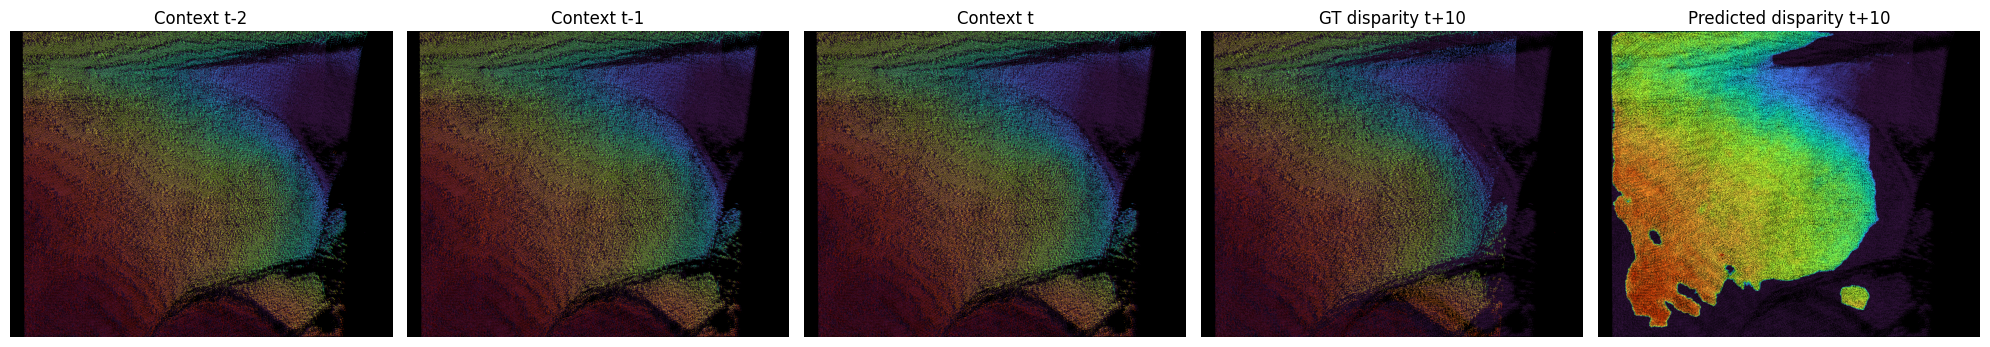

In [ ]:
swin_unetr.eval()

ctx_batch, tgt_batch = next(iter(val_loader))
ctx_batch = ctx_batch.to(device)
tgt_batch = tgt_batch.to(device)

with torch.no_grad():
    pred_batch = swin_unetr(ctx_batch)

ctx_np  = ctx_batch[0].cpu().numpy()      # [3,H,W]
tgt_np  = tgt_batch[0, 0].cpu().numpy()   # [H,W]
pred_np = pred_batch[0, 0].cpu().numpy()  # [H,W]

vmin, vmax, valid_union = compute_global_range_and_mask(ctx_np, tgt_np, pct=(5, 95))

frames = [
    ctx_np[0],   # t-2
    ctx_np[1],   # t-1
    ctx_np[2],   # t
    tgt_np,      # t+10 GT
    pred_np,     # t+10 Pred
]

titles = [
    "Context t-2",
    "Context t-1",
    "Context t",
    "GT disparity t+10",
    "Predicted disparity t+10",
]

colored_frames = [
    disp_to_raft_color_fixed_range(f, vmin, vmax, valid_union)
    for f in frames
]

plt.figure(figsize=(20, 4))
for i, (img, title) in enumerate(zip(colored_frames, titles), start=1):
    plt.subplot(1, 5, i)
    plt.title(title)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
print("Are they exactly equal? ->", np.allclose(pred_np, tgt_np))
abs_diff = np.abs(pred_np - tgt_np)
print("Mean |pred - gt|:", abs_diff.mean())
print("Max  |pred - gt|:", abs_diff.max())


Are they exactly equal? -> False
Mean |pred - gt|: 22.78154
Max  |pred - gt|: 250.62354


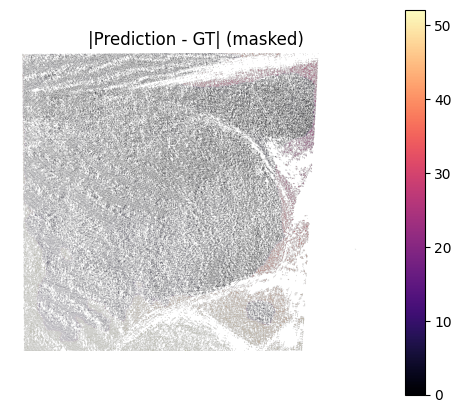

In [ ]:
valid_mask = tgt_np > 0
err = np.abs(pred_np - tgt_np)
err[~valid_mask] = np.nan

plt.figure(figsize=(6, 5))
plt.title("|Prediction - GT| (masked)")
plt.imshow(err, cmap="magma", vmin=0, vmax=np.nanpercentile(err, 95))
plt.colorbar()
plt.axis("off")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FEATURE_SIZE = 48

swin_unetr = SwinUNETR(
    in_channels=3,
    out_channels=1,
    feature_size=FEATURE_SIZE,
    spatial_dims=2,
    use_checkpoint=True,
).to(device)

swin_unetr.eval()
with torch.no_grad():
    dummy = torch.randn(1, 3, Hc, Wc, device=device)
    out = swin_unetr(dummy)
print("Dummy output shape:", out.shape)

Dummy output shape: torch.Size([1, 1, 1024, 1280])


In [ ]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.cm as cm
import cv2
from pathlib import Path

SCALE_FACTOR = DISP_SCALE

def load_disp_float(path):
    """Load uint16 disparity PNG -> float (already /256)."""
    disp_u16 = imageio.imread(path)
    disp = disp_u16.astype(np.float32) / SCALE_FACTOR
    return disp

def disp_to_raft_color_fixed_range(disp_float, vmin, vmax, valid_mask):
    """
    Apply RAFT-style turbo colormap with fixed vmin/vmax and GT-based mask.
    disp_float: [H,W] float
    valid_mask: [H,W] bool
    """
    d = np.asarray(disp_float, dtype=np.float32)
    d_clipped = np.clip(d, vmin, vmax)
    d_norm = (d_clipped - vmin) / (vmax - vmin + 1e-8)
    d_norm[~valid_mask] = np.nan

    turbo = cm.get_cmap("turbo")
    colored = turbo(d_norm)[:, :, :3]  # [H,W,3], 0–1
    colored = np.nan_to_num(colored) * 255.0
    return colored.astype(np.uint8)


In [ ]:
CONTEXT_LEN = 3
HORIZON = 10

DATA_ROOT = BASE_DIR / "scared_data" / "train" / "dataset_3" /
kf_id = 1
kf_dir = DATA_ROOT / f"keyframe_{kf_id}"
rgb_path = kf_dir / "data" / "rgb.mp4"
disp_dir = kf_dir / "data" / "disparity"

print("Keyframe dir:", kf_dir)
print("RGB:", rgb_path)
print("Disp dir:", disp_dir)

disp_paths = sorted(
    p for p in disp_dir.glob("*.png")
    if not p.name.startswith("colored")
)
print("Num disparity frames:", len(disp_paths))

# RGB video reader (stacked vertically: top=left, bottom=right)
rgb_reader = imageio.get_reader(str(rgb_path), "ffmpeg")
num_rgb_frames = rgb_reader.count_frames()
print("Num RGB frames:", num_rgb_frames)

# Output video writer
out_dir = BASE_DIR / "videos"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "dt3_kf1_left-right_gt-pred_disp.mp4"
writer = imageio.get_writer(str(out_path), fps=10)
print("Writing to:", out_path)

swin_unetr.eval()

# t must allow t-2, t-1, t and t+10 to exist in both disparity and rgb
max_t = min(len(disp_paths), num_rgb_frames) - HORIZON
start_t = CONTEXT_LEN - 1

for t in range(start_t, max_t):
    rgb_frame = rgb_reader.get_data(t)        # [H_rgb, W_rgb, 3]
    H_rgb, W_rgb, _ = rgb_frame.shape
    mid = H_rgb // 2
    left_t  = rgb_frame[:mid, :, :]
    right_t = rgb_frame[mid:, :, :]

    ctx_indices = [t - 2, t - 1, t]
    ctx_disps = [load_disp_float(disp_paths[i]) for i in ctx_indices]  # list of [Hc,Wc]
    ctx_arr = np.stack(ctx_disps, axis=0)                               # [3,Hc,Wc]
    ctx_tensor = torch.from_numpy(ctx_arr).unsqueeze(0).float().to(device)

    tgt_idx = t + HORIZON
    gt_disp = load_disp_float(disp_paths[tgt_idx])   # [Hc,Wc]
    valid_mask = gt_disp > 0


    with torch.no_grad():
        pred_tensor = swin_unetr(ctx_tensor)         # [1,1,Hc,Wc]
    pred_disp = pred_tensor[0, 0].cpu().numpy()


    gt_vals = gt_disp[valid_mask]
    vmin, vmax = np.percentile(gt_vals, (5, 95))
    if vmax <= vmin:
        vmax = vmin + 1e-6

    gt_color   = disp_to_raft_color_fixed_range(gt_disp,   vmin, vmax, valid_mask)
    pred_color = disp_to_raft_color_fixed_range(pred_disp, vmin, vmax, valid_mask)


    Hc, Wc, _ = gt_color.shape
    target_h = left_t.shape[0]
    scale = target_h / float(Hc)
    new_w = int(Wc * scale)

    gt_color_res   = cv2.resize(gt_color,   (new_w, target_h), interpolation=cv2.INTER_LINEAR)
    pred_color_res = cv2.resize(pred_color, (new_w, target_h), interpolation=cv2.INTER_LINEAR)

    left_panel  = left_t.astype(np.uint8)
    right_panel = right_t.astype(np.uint8)


    frame_out = np.concatenate(
        [left_panel, right_panel, gt_color_res, pred_color_res],
        axis=1
    )

    writer.append_data(frame_out)

writer.close()
rgb_reader.close()
print("Done, video saved at:", out_path)


Keyframe dir: /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_3/dataset_3/keyframe_1
RGB: /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_3/dataset_3/keyframe_1/data/rgb.mp4
Disp dir: /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_3/dataset_3/keyframe_1/data/disparity
Num disparity frames: 329
Num RGB frames: 329
Writing to: /content/drive/Shareddrives/TissueMotionForecasting/videos/dt3_kf1_left-right_gt-pred_disp.mp4


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


Done, video saved at: /content/drive/Shareddrives/TissueMotionForecasting/videos/dt3_kf1_left-right_gt-pred_disp.mp4
